# Wind Turbine Study

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.patches import Ellipse

import re

import time

import math

import seaborn as sns

import warnings

from sklearn import metrics, preprocessing
from sklearn.cluster import DBSCAN
import sklearn.mixture as mixture
from sklearn.preprocessing import StandardScaler

from operator import mul

from scipy.stats import mstats
import scipy.linalg as la

In [2]:
warnings.filterwarnings('ignore')


%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (15,8)
sns.set(color_codes=True)

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

## Load Data

In [4]:
cols = ['Timestamp','ACTIVE_POWER','WIND_SPEED','BLADE_1_POS']

In [5]:
wt = pd.read_csv("WT056_Actuals_20170719-115436_new.csv", sep=';', decimal=".",parse_dates=['Timestamp'], date_parser=dateparse)
wt = wt[cols]

In [6]:
wt.shape

(28126, 4)

In [7]:
wt.head(10)

,Timestamp,ACTIVE_POWER,WIND_SPEED,BLADE_1_POS
0,2016-02-01 01:02:01,503.3,8.0,-1.35
1,2016-02-01 01:11:36,615.0,7.9,-1.26
2,2016-02-01 01:21:55,382.0,8.6,-0.26
3,2016-02-01 01:31:44,365.7,7.5,-0.26
4,2016-02-01 01:41:54,366.6,7.8,-0.26
5,2016-02-01 01:50:55,315.9,6.2,-0.26
6,2016-02-01 02:00:49,583.3,9.0,-1.37
7,2016-02-01 02:10:29,472.8,9.0,-0.10
8,2016-02-01 02:22:07,552.2,7.3,-0.99
9,2016-02-01 02:31:55,966.9,10.0,-2.01


In [8]:
wt.tail()

,Timestamp,ACTIVE_POWER,WIND_SPEED,BLADE_1_POS
28121,2017-07-17 12:20:30,621.2,7.55,-0.115
28122,2017-07-17 12:30:31,516.8,6.95,14.840
28123,2017-07-17 12:40:32,-13.5,4.80,31.570
28124,2017-07-17 12:40:36,976.3,9.10,-1.890
28125,2017-07-17 12:50:31,519.4,6.95,-0.140


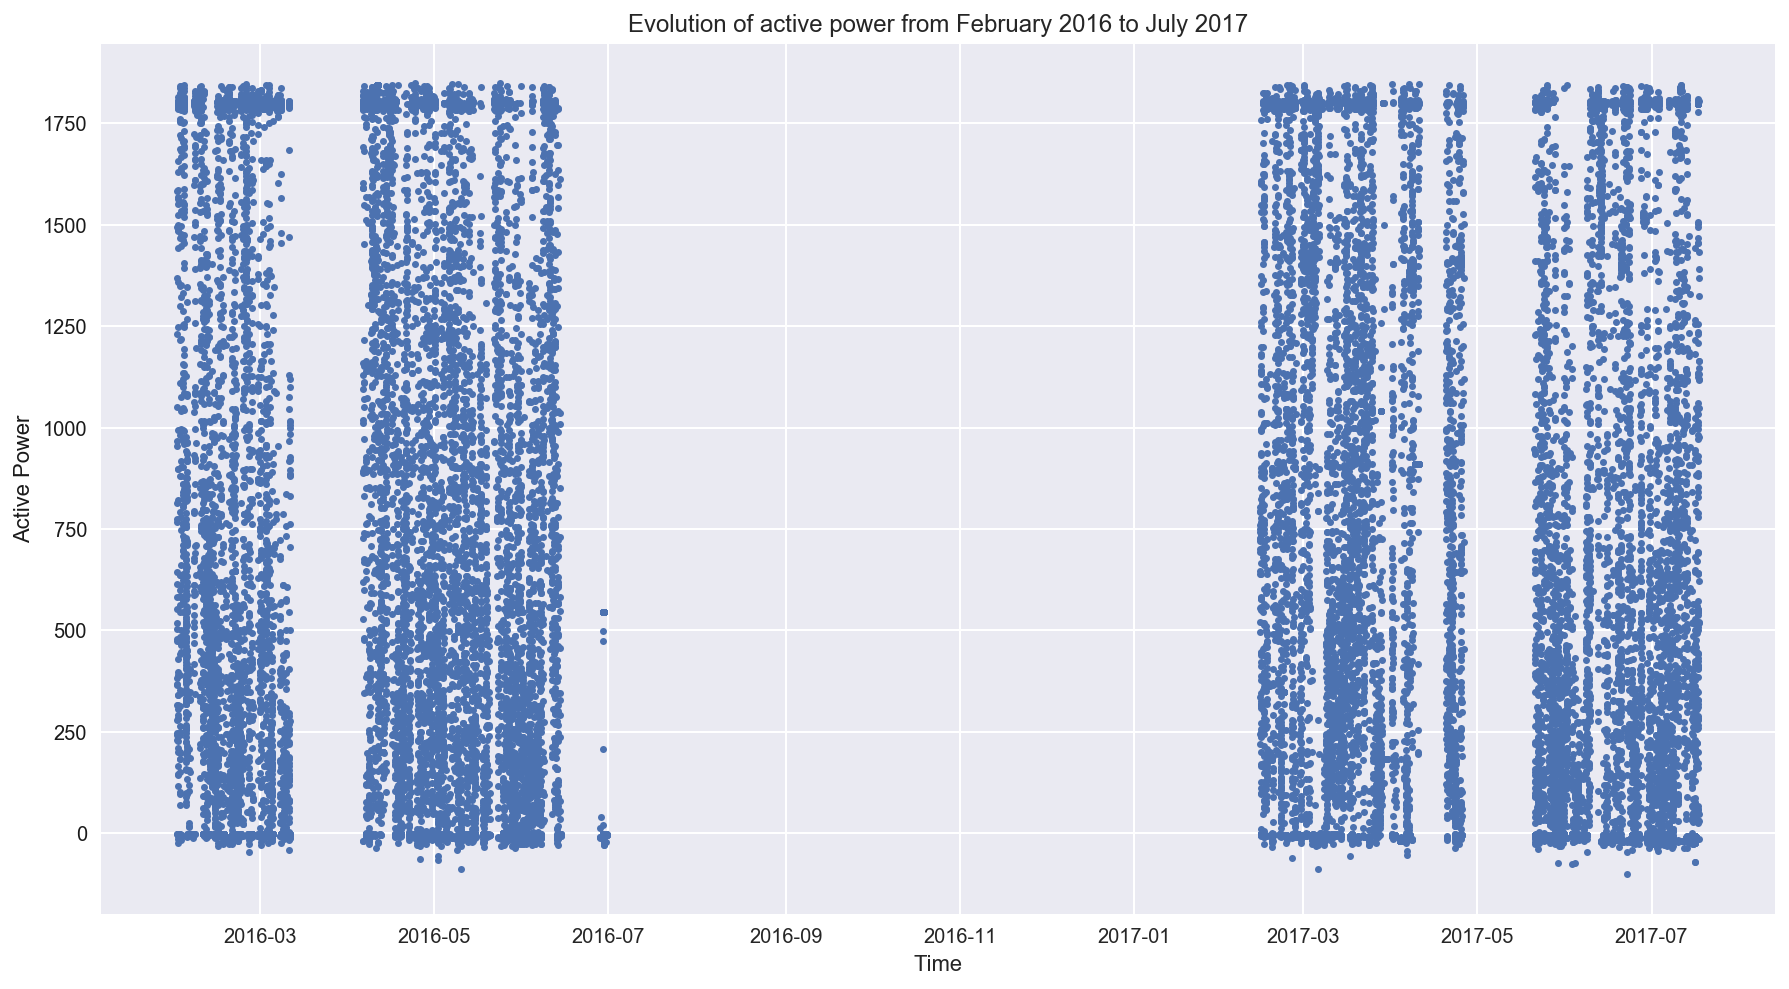

In [9]:
t = wt['Timestamp']
s1 = wt['ACTIVE_POWER']

plt.plot(t, s1, 'b.')
plt.xlabel('Time')
plt.ylabel('Active Power', color='k')
plt.tick_params('y', colors='k')
plt.title("Evolution of active power from February 2016 to July 2017")
plt.show()

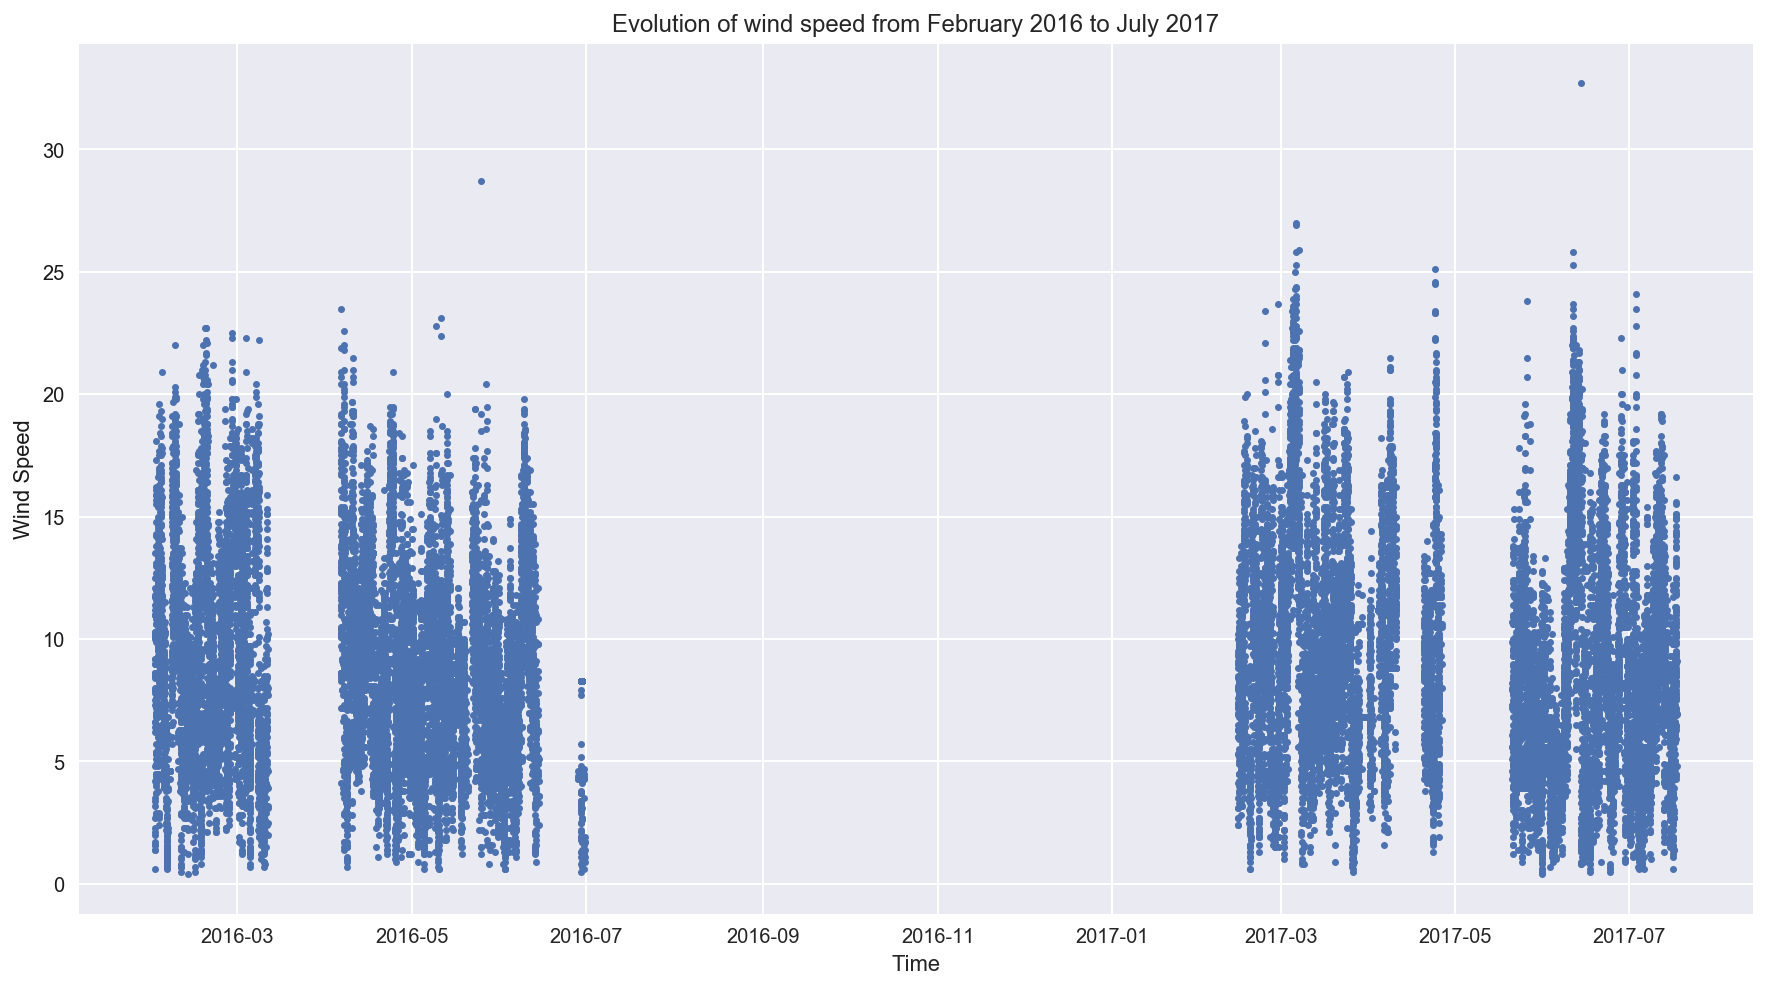

In [10]:
t = wt['Timestamp']
s1 = wt['WIND_SPEED']

plt.plot(t, s1, 'b.')
plt.xlabel('Time')
plt.ylabel('Wind Speed', color='k')
plt.tick_params('y', colors='k')
plt.title("Evolution of wind speed from February 2016 to July 2017")
plt.show()

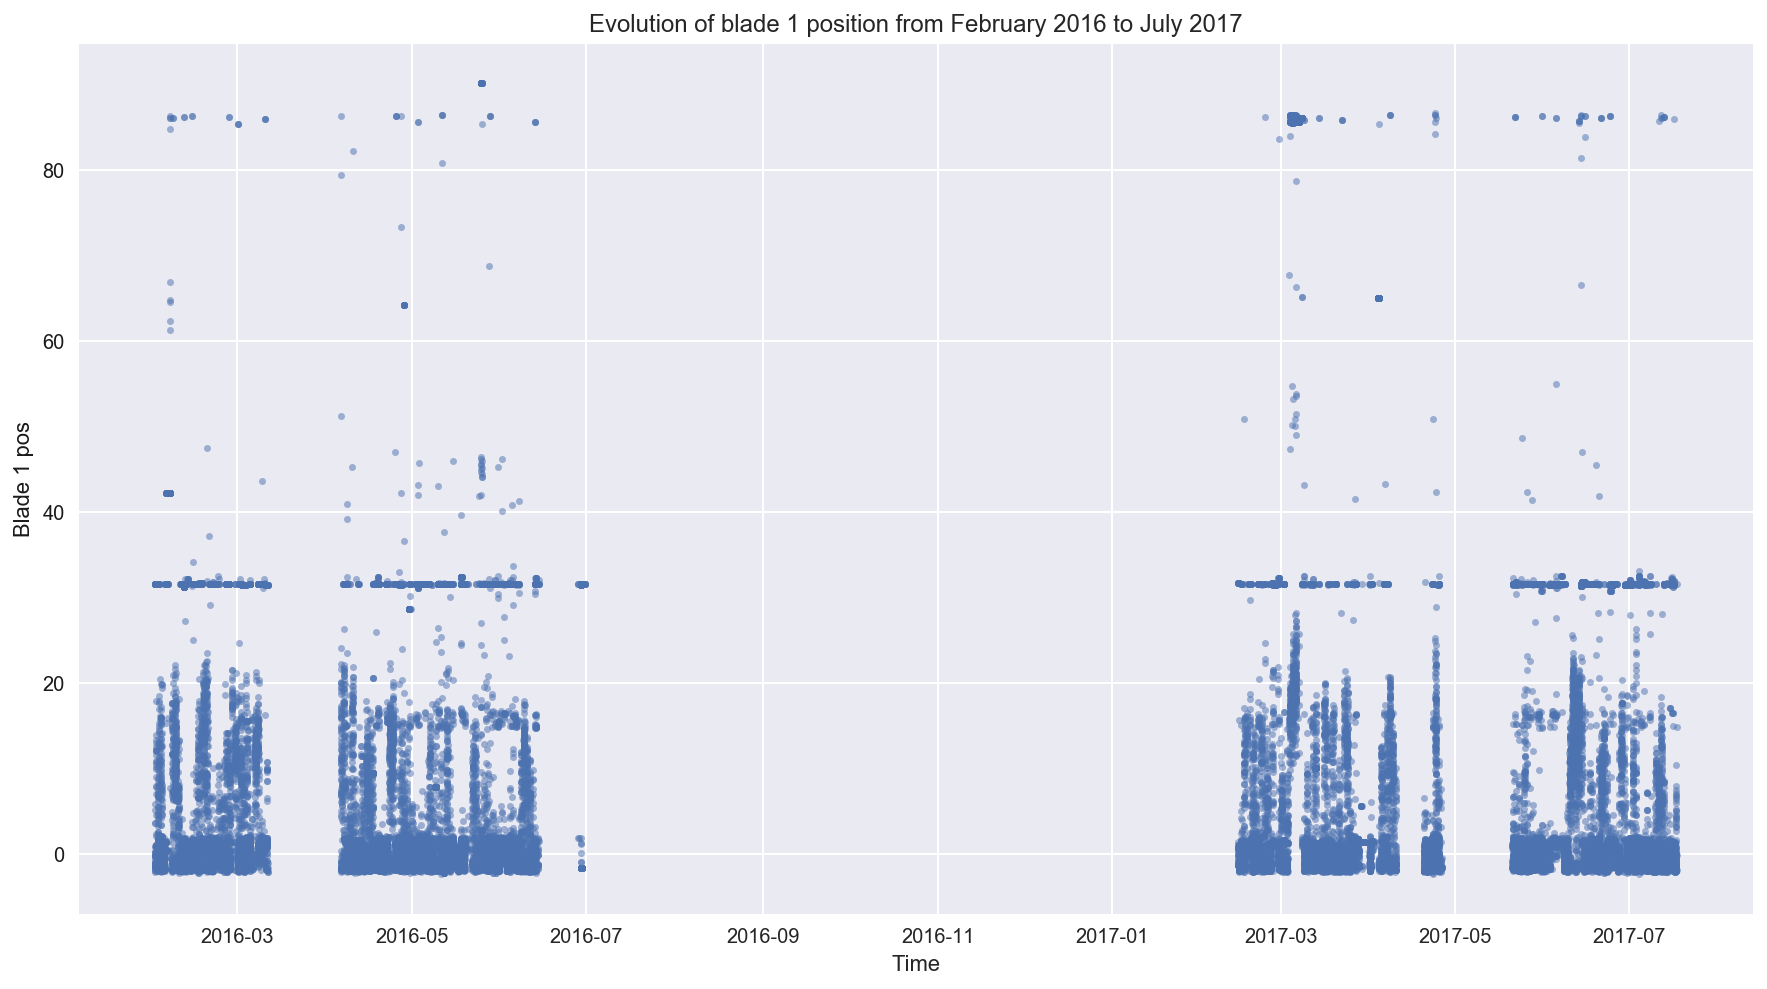

In [11]:
t = wt['Timestamp']
s1 = wt['BLADE_1_POS']

plt.plot(t, s1, 'b.',alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Blade 1 pos', color='k')
plt.tick_params('y', colors='k')
plt.title("Evolution of blade 1 position from February 2016 to July 2017")
plt.show()

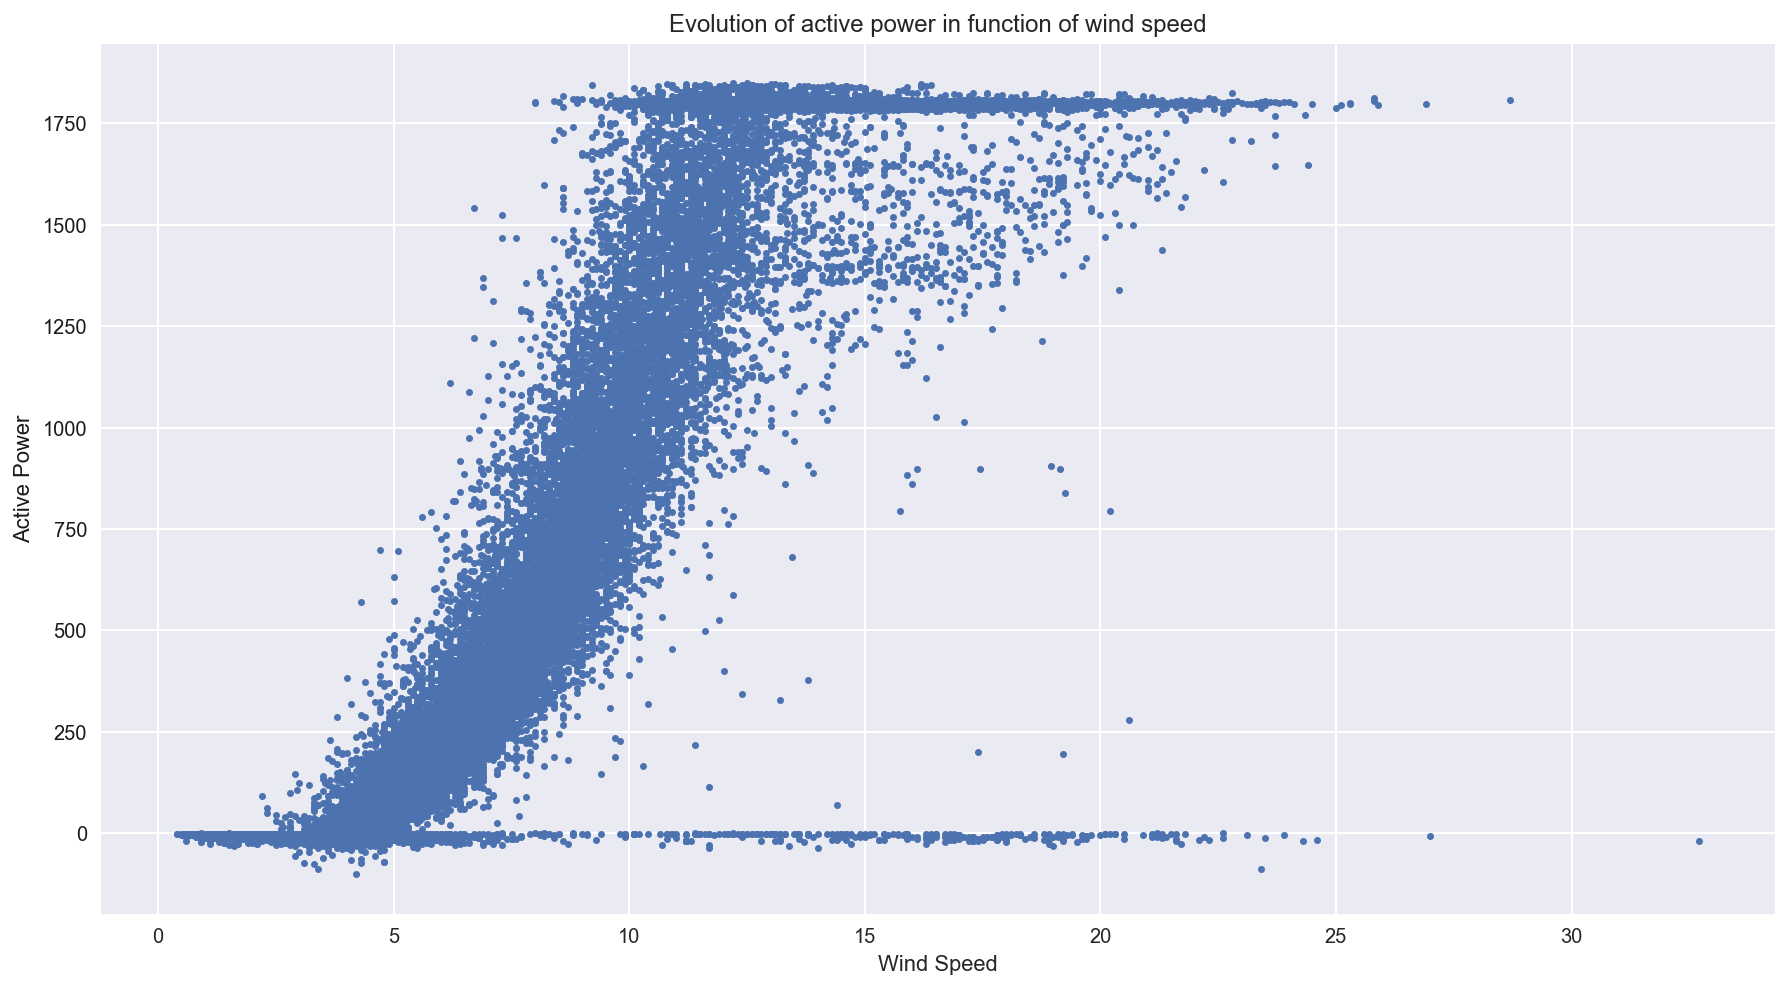

In [12]:
t = wt['WIND_SPEED']
s1 = wt['ACTIVE_POWER']

plt.plot(t, s1, 'b.')
plt.xlabel('Wind Speed')
plt.ylabel('Active Power', color='k')
plt.tick_params('y', colors='k')
plt.title("Evolution of active power in function of wind speed")
plt.show()

## Preprocessing

In [13]:
wt2 = wt.copy()
wt2 = wt2[wt2["WIND_SPEED"]<=40]
wt2 = wt2[wt2["WIND_SPEED"]>=2.5]
wt2 = wt2[wt2["ACTIVE_POWER"]>0]
wt2 = wt2[~((wt2["BLADE_1_POS"]>=20) & (wt2["ACTIVE_POWER"]<=max(wt2["ACTIVE_POWER"])))]
wt2 = wt2[['Timestamp','WIND_SPEED','ACTIVE_POWER']]

In [14]:
wt2.head(10)

,Timestamp,WIND_SPEED,ACTIVE_POWER
0,2016-02-01 01:02:01,8.0,503.3
1,2016-02-01 01:11:36,7.9,615.0
2,2016-02-01 01:21:55,8.6,382.0
3,2016-02-01 01:31:44,7.5,365.7
4,2016-02-01 01:41:54,7.8,366.6
5,2016-02-01 01:50:55,6.2,315.9
6,2016-02-01 02:00:49,9.0,583.3
7,2016-02-01 02:10:29,9.0,472.8
8,2016-02-01 02:22:07,7.3,552.2
9,2016-02-01 02:31:55,10.0,966.9


In [15]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the Ellipse
    for nsig in range(1, 3):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                            angle, **kwargs))
    return position,angle

In [16]:
def plot_gmm(gmm, X, label=True, ax=None):
    
    fig, ax = plt.subplots()      
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], s=5, zorder=2,c='b',alpha=0.5)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=dot_size, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    ls = []
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        pos, angle = draw_ellipse(pos, covar, ax=ax,  edgecolor='r', lw=4, facecolor='none',zorder=10)
        ls.append((pos,angle))
    
    plt.axvline(x=6, ymin=0, ymax = 1750, linewidth=2, color='k')
    plt.axvline(x=15.5, ymin=0, ymax = 1750, linewidth=2, color='k')
    plt.xlabel('Wind Speed')
    plt.ylabel('Active Power', color='k')
    plt.title("Regime selection")
    plt.show()

In [17]:
def regimeSelection(wt): 
    dpgmm = mixture.BayesianGaussianMixture(n_components=3,covariance_type='full').fit(wt2.iloc[:,1:3].values)
    
    plot_gmm(dpgmm, wt2.iloc[:,1:3].values)
    
    wt = wt[wt["WIND_SPEED"] >= 6]
    wt = wt[wt["WIND_SPEED"] <= 15.5]
    plt.scatter(wt["WIND_SPEED"],wt["ACTIVE_POWER"],s=15)
    plt.title("Quasi linear functional regime")
    plt.xlabel('Wind Speed')
    plt.ylabel('Active Power', color='k')
    plt.show()

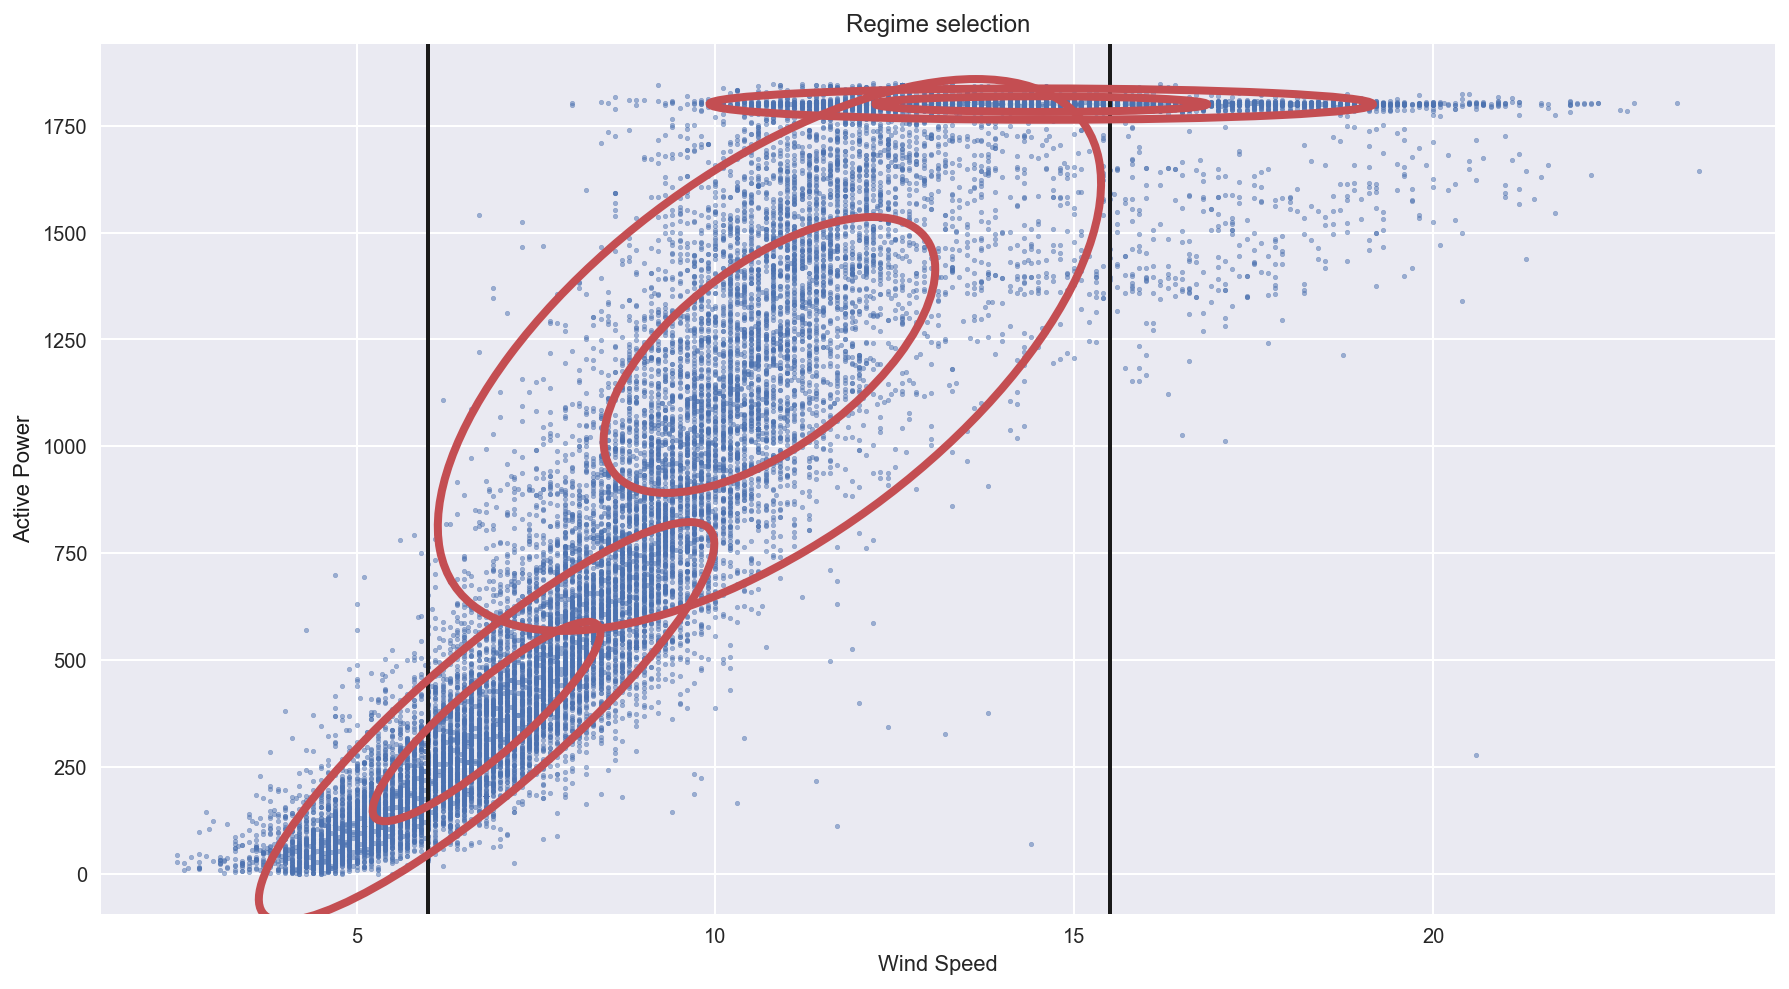

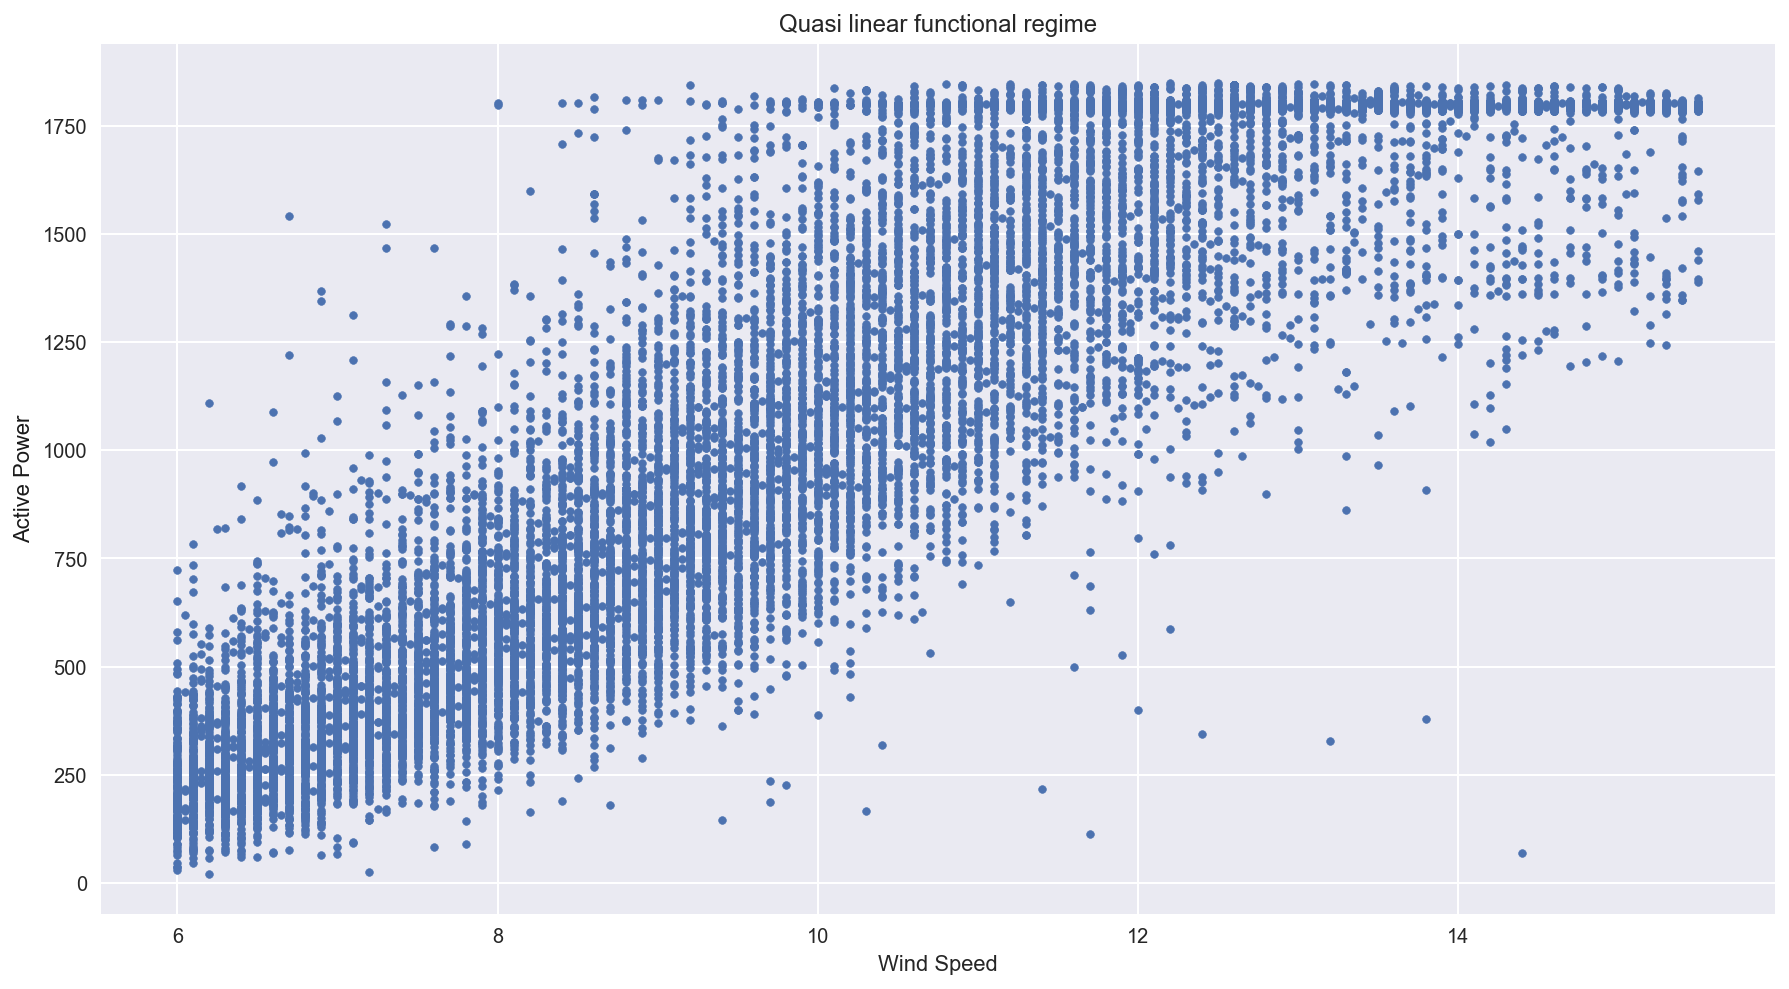

In [18]:
regimeSelection(wt2)

## Outlier elimination with DBSCAN

In [19]:
X = wt2.iloc[:,1:3].values

X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.1, min_samples=35).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 1


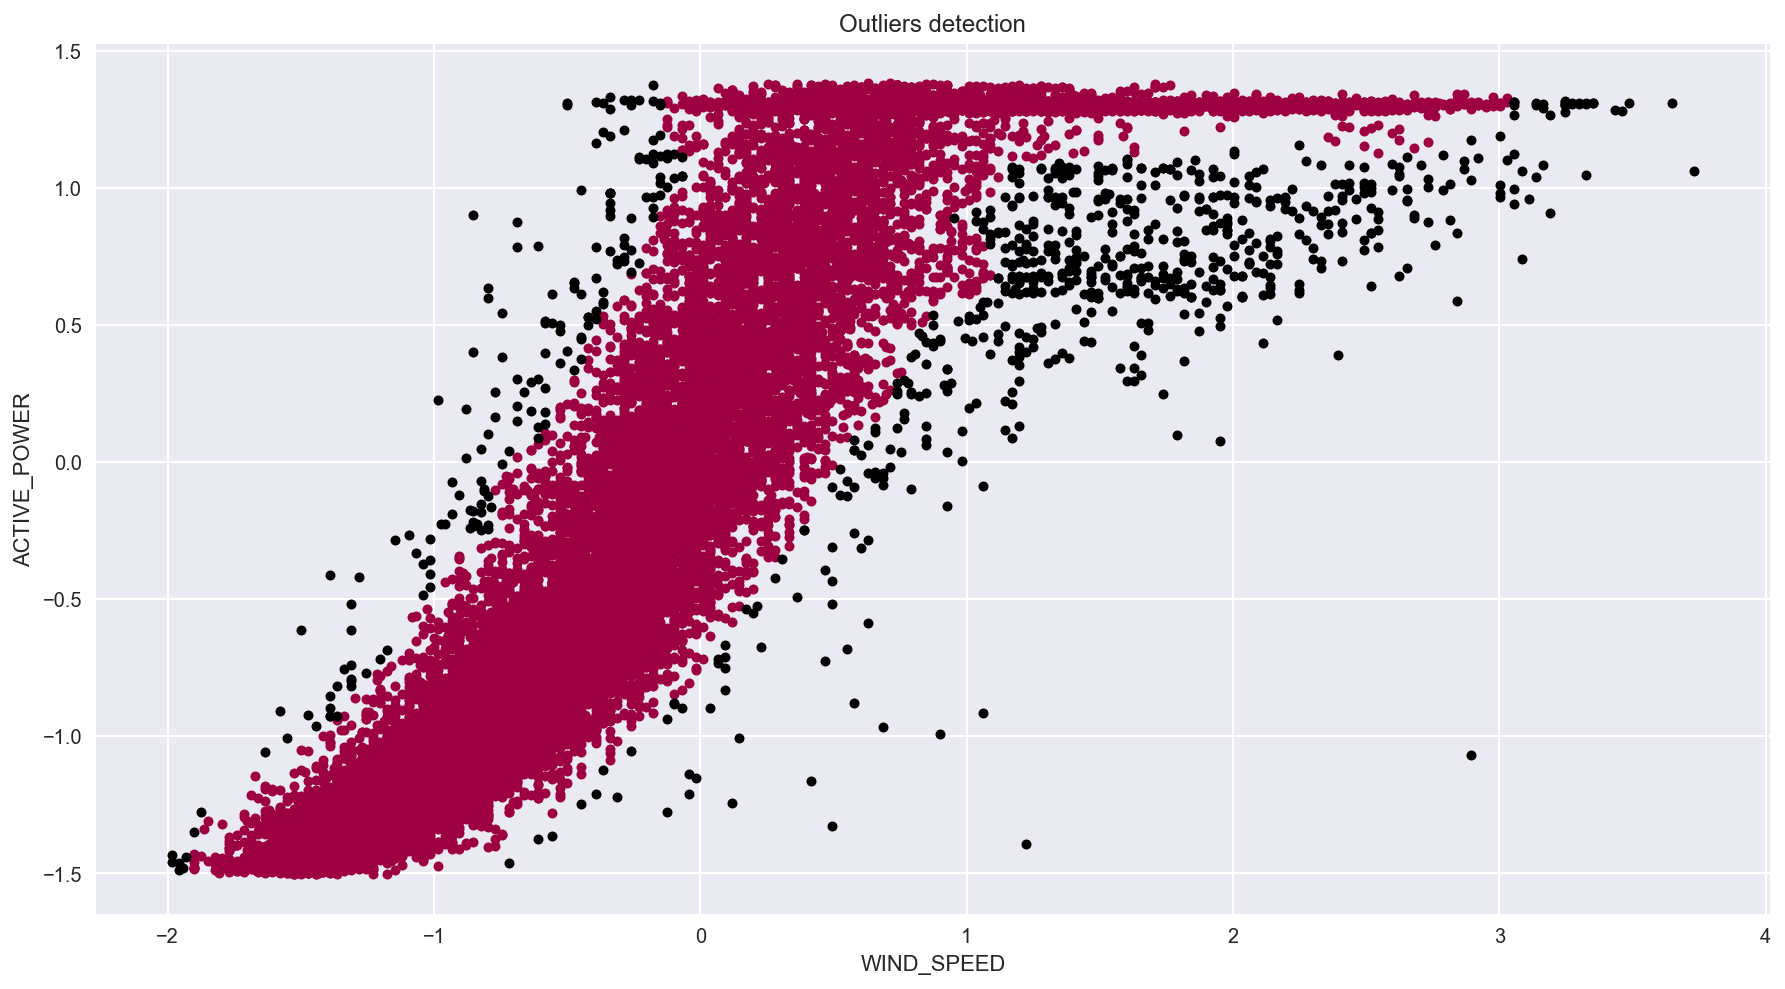

In [20]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)
plt.xlabel('WIND_SPEED')
plt.ylabel('ACTIVE_POWER')
plt.title('Outliers detection')
plt.show()

In [21]:
wt2['label'] = db.labels_

In [22]:
cleanwt = wt2[wt2['label']==0]

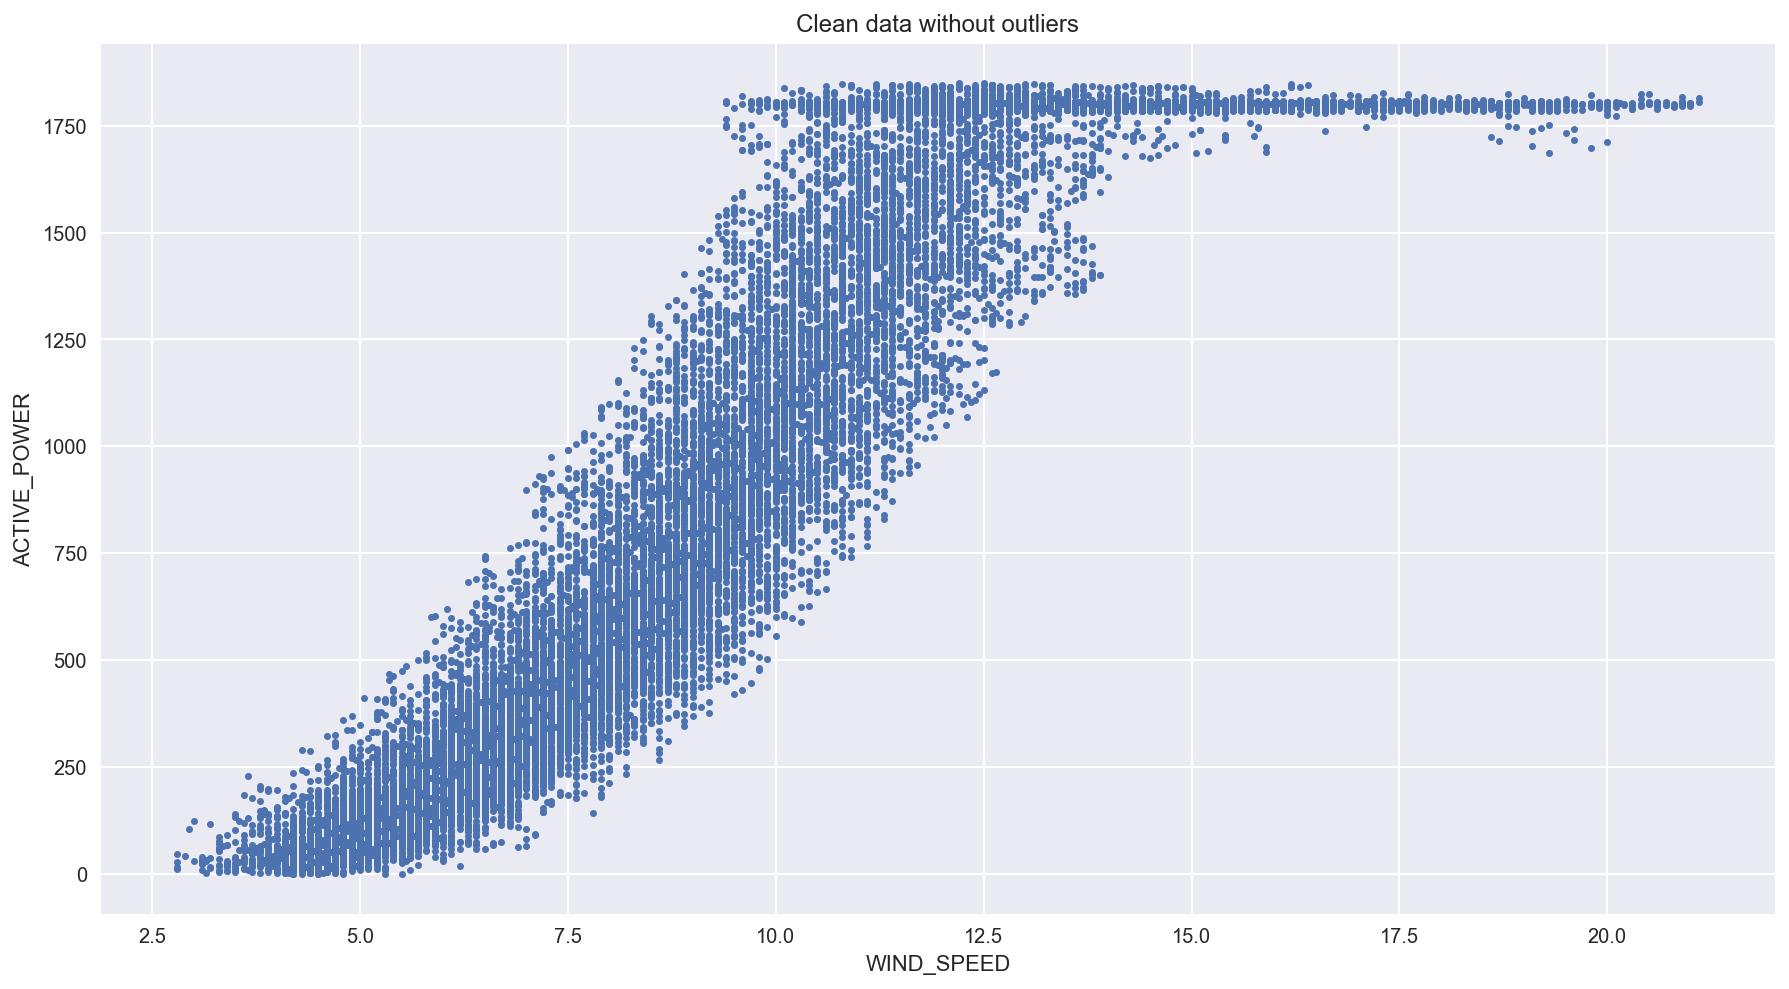

In [23]:
plt.plot(cleanwt["WIND_SPEED"],cleanwt["ACTIVE_POWER"],'.')
plt.title('Clean data without outliers')
plt.xlabel("WIND_SPEED")
plt.ylabel("ACTIVE_POWER")
plt.show()

## Detect degraded running with PC2_DEV

In [24]:
cleanwt['week'] = list(map(lambda x: str(x.isocalendar()[1])+str("-")+str(x.isocalendar()[0]), cleanwt["Timestamp"]))

In [25]:
cleanwt.head()

,Timestamp,WIND_SPEED,ACTIVE_POWER,label,week
0,2016-02-01 01:02:01,8.0,503.3,0,5-2016
1,2016-02-01 01:11:36,7.9,615.0,0,5-2016
2,2016-02-01 01:21:55,8.6,382.0,0,5-2016
3,2016-02-01 01:31:44,7.5,365.7,0,5-2016
4,2016-02-01 01:41:54,7.8,366.6,0,5-2016


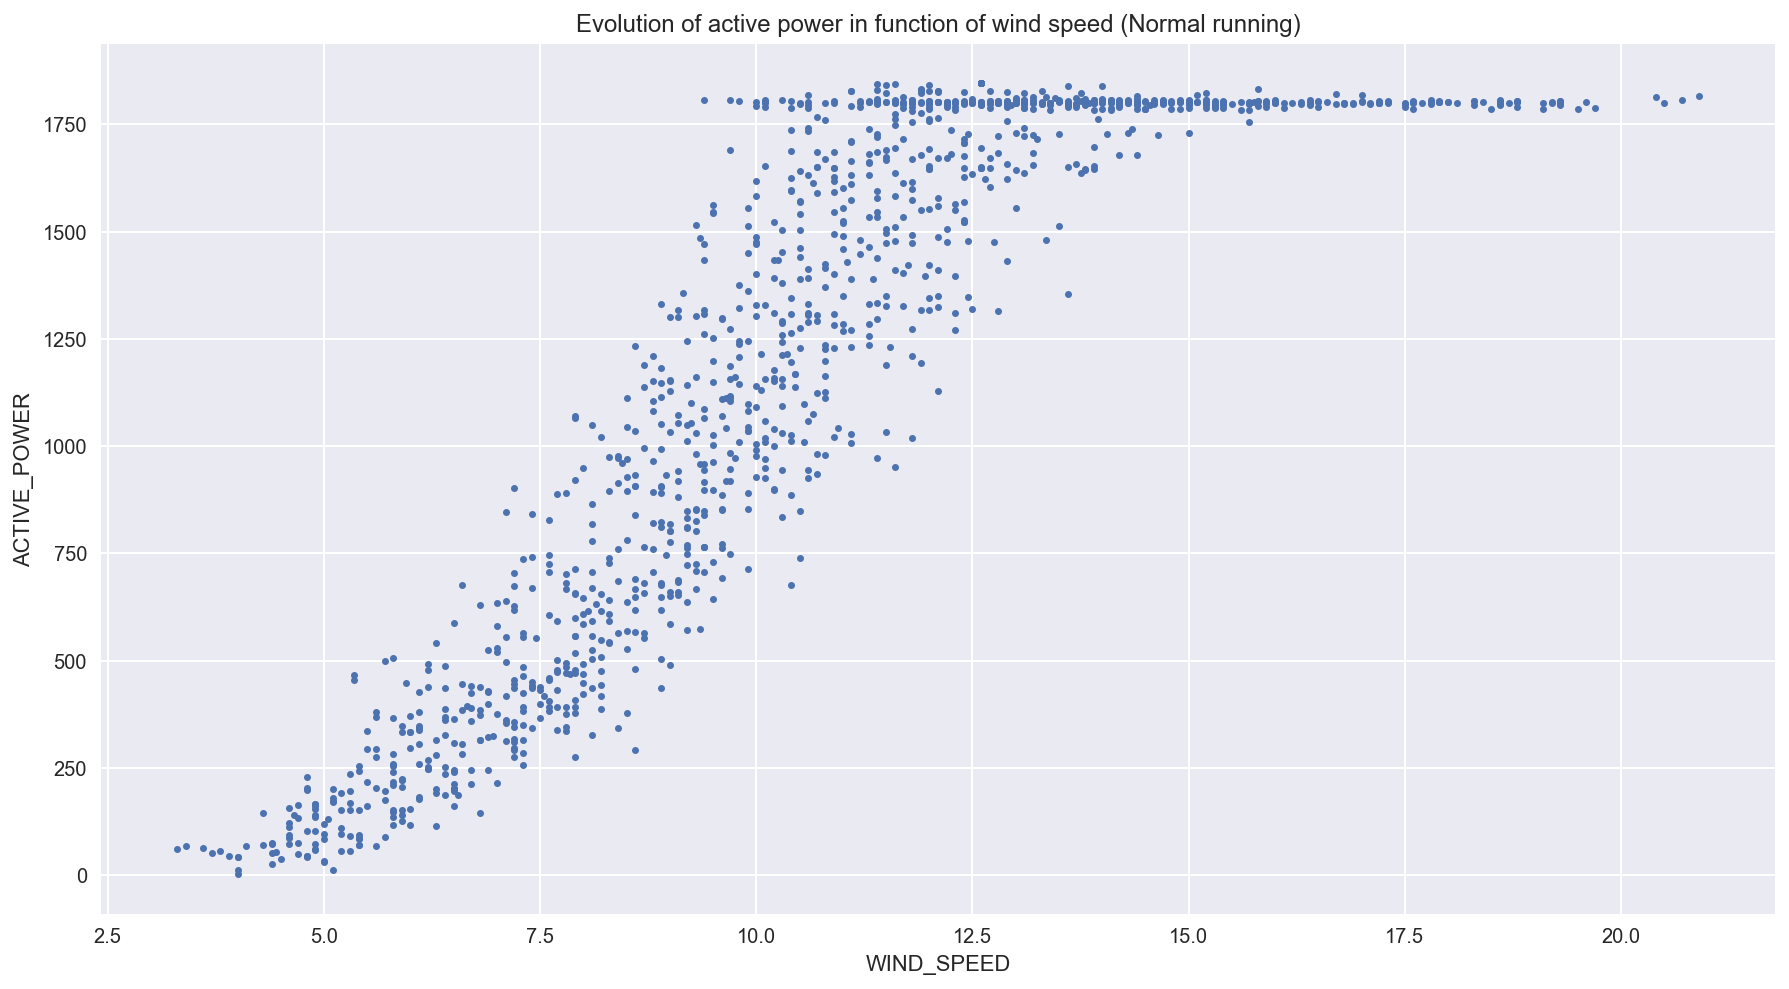

In [26]:
good = cleanwt[cleanwt['week'].isin(['14-2016','15-2016'])]
plt.plot(good["WIND_SPEED"],good["ACTIVE_POWER"],'.')
plt.title("Evolution of active power in function of wind speed (Normal running)")
plt.xlabel("WIND_SPEED")
plt.ylabel("ACTIVE_POWER")
plt.show()

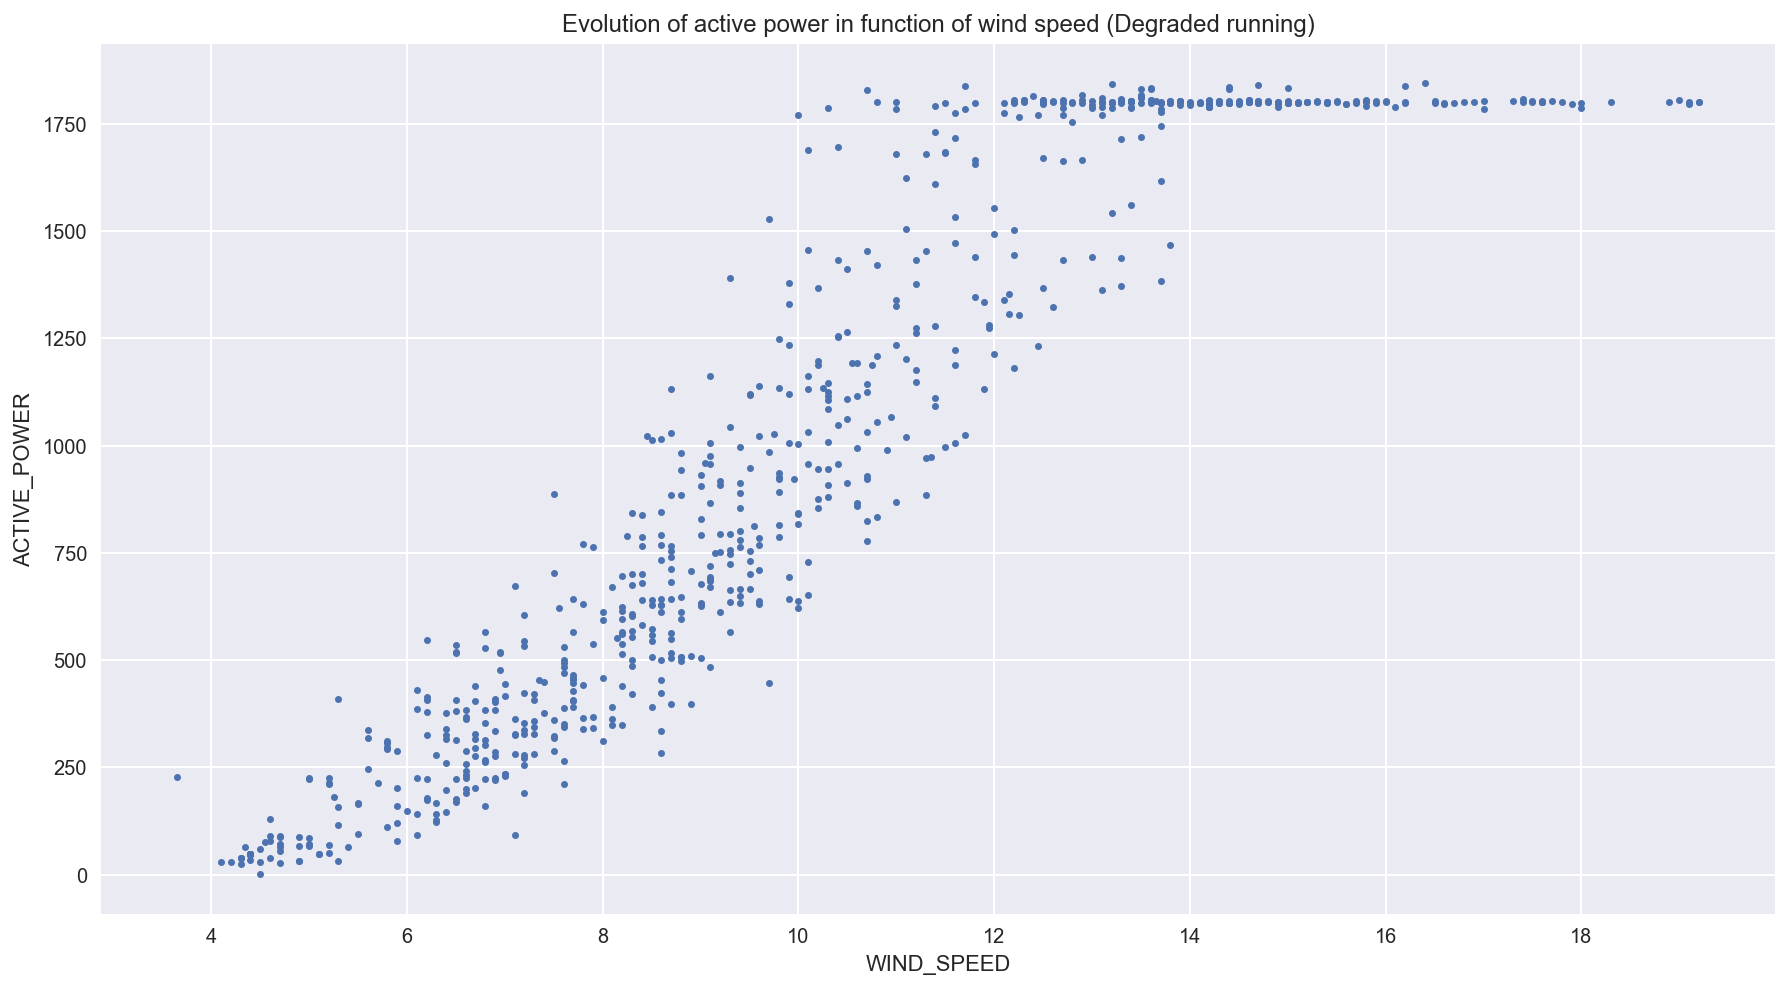

In [27]:
bad = cleanwt[cleanwt['week'].isin(['28-2017', '29-2017'])]
plt.plot(bad["WIND_SPEED"],bad["ACTIVE_POWER"],'.')
plt.title("Evolution of active power in function of wind speed (Degraded running)")
plt.xlabel("WIND_SPEED")
plt.ylabel("ACTIVE_POWER")
plt.show()

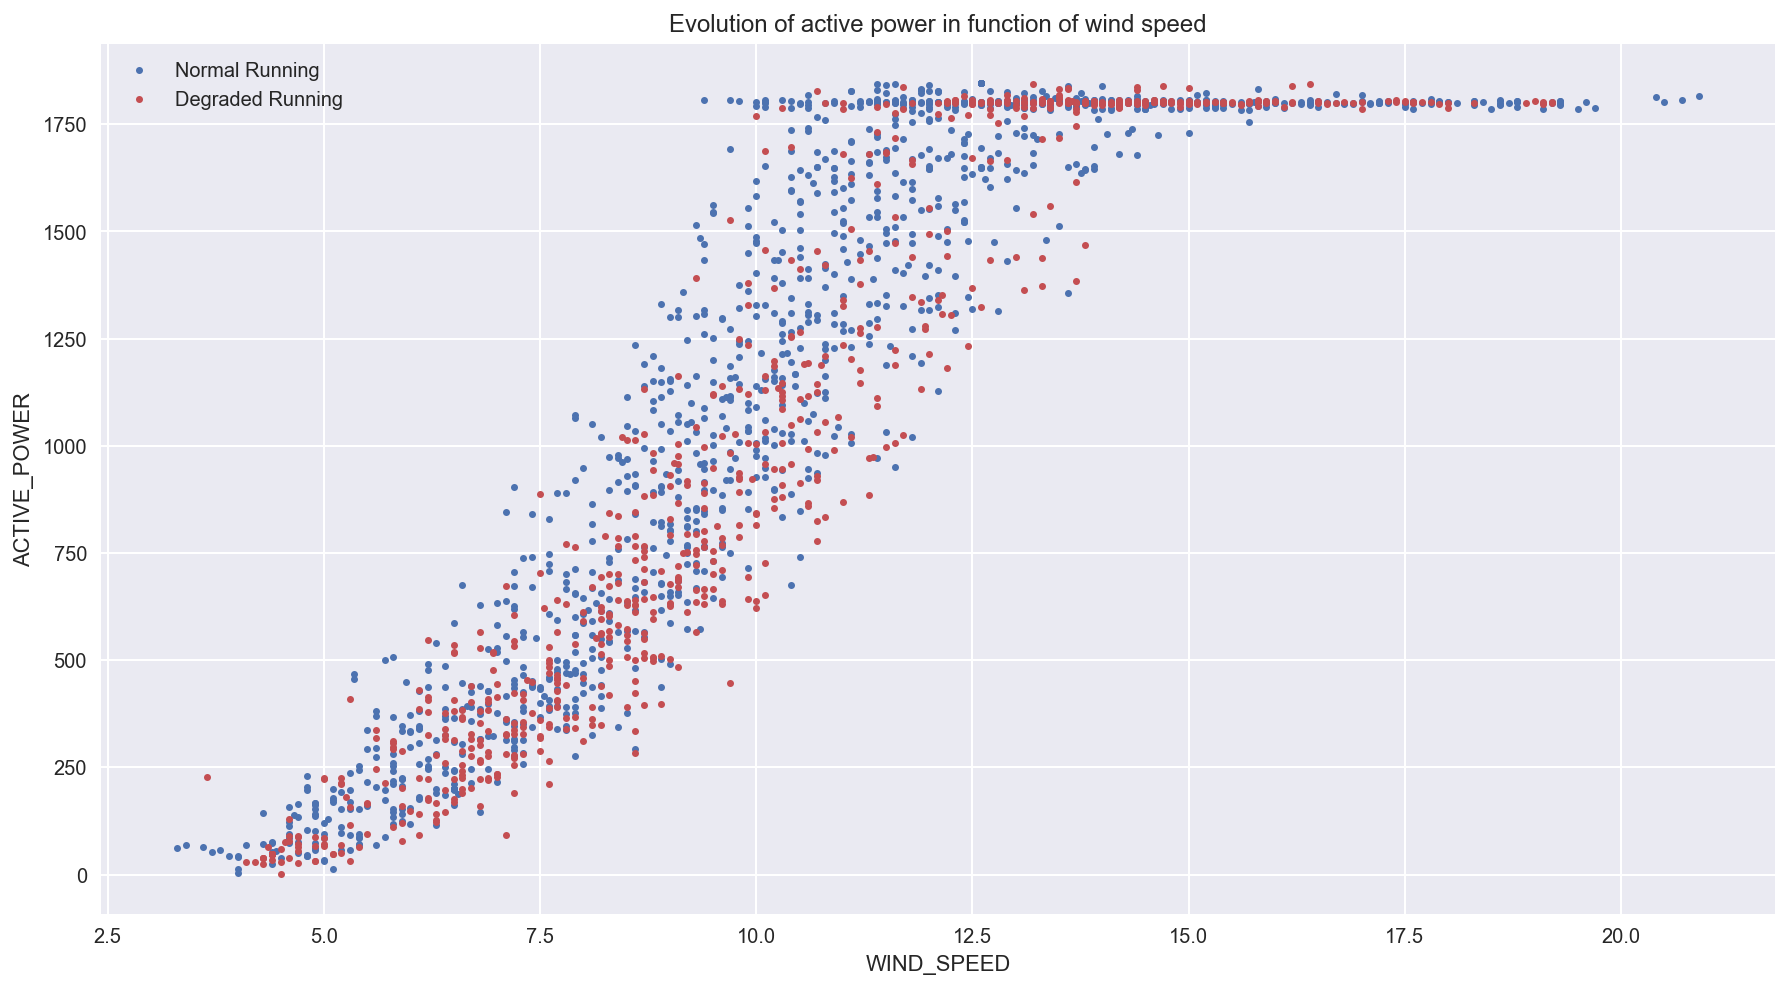

In [28]:
plt.plot(good["WIND_SPEED"],good["ACTIVE_POWER"],'b.')
plt.plot(bad["WIND_SPEED"],bad["ACTIVE_POWER"],'r.')
plt.title("Evolution of active power in function of wind speed")
plt.xlabel("WIND_SPEED")
plt.ylabel("ACTIVE_POWER")
plt.legend(["Normal Running", "Degraded Running"])
plt.show()

In [29]:
def getCenterLine(mini,maxi,pas,data):
    xx = np.arange(mini,maxi,pas)
    cpt = 0
    d = {}
    for i in xx:
        if i == mini:
            d[i] = data[data["WIND_SPEED"]==i]
        else:
            d[i] = data[(data["WIND_SPEED"]<=i)&(data["WIND_SPEED"]>xx[cpt-1])]
        cpt+=1
    yy = []
    for i in xx:
        yy.append(np.mean(d[i]["ACTIVE_POWER"]))
    tmp = pd.DataFrame()
    tmp["x"] = xx
    tmp["y"] = yy
    return tmp

In [30]:
def algo(g,b):    

    a = pd.merge(g, b, how='outer')
    
    d = a.values
    
    dp = preprocessing.scale(d,with_mean=True, with_std=True)
    
    s = np.dot(dp.transpose(),dp)

    v1,p1 = la.eig(s)
    
    v1=np.diag(v1)

    pc1 = np.dot(dp,p1)

    d1 = np.std(pc1[:,1])

    B = pd.merge(g, g, how='outer')

    e = B.values

    ep = preprocessing.scale(e,with_mean=True, with_std=True)

    t = np.dot(ep.transpose(),ep)

    v2,p2 = la.eig(t)
    v2=np.diag(v2)

    pc2 = np.dot(ep,p2)

    d2 = np.std(pc2[:,1])
    
    return ((d1/d2)-1)

In [31]:
weeks = [['5-2016','6-2016'],['6-2016','7-2016'], ['7-2016','8-2016'],['8-2016','9-2016'],['9-2016','10-2016'],['18-2016','19-2016'],['19-2016','20-2016'],['20-2016','21-2016'],['21-2016','22-2016'],['22-2016','23-2016'],['23-2016','24-2016'],['07-2017','8-2017'],['8-2017','9-2017'],
 ['09-2017','10-2017'],['10-2017','11-2017'],['11-2017','12-2017'],['12-2017','13-2017'],['13-2017','14-2017'],['14-2017','15-2017'],['16-2017','17-2017'],['20-2017','21-2017'],['21-2017','22-2017'],['22-2017','23-2017'],['23-2017','24-2017'],['24-2017','25-2017'],
 ['25-2017','26-2017'],['26-2017','27-2017'],['27-2017','28-2017'],['28-2017','29-2017']]

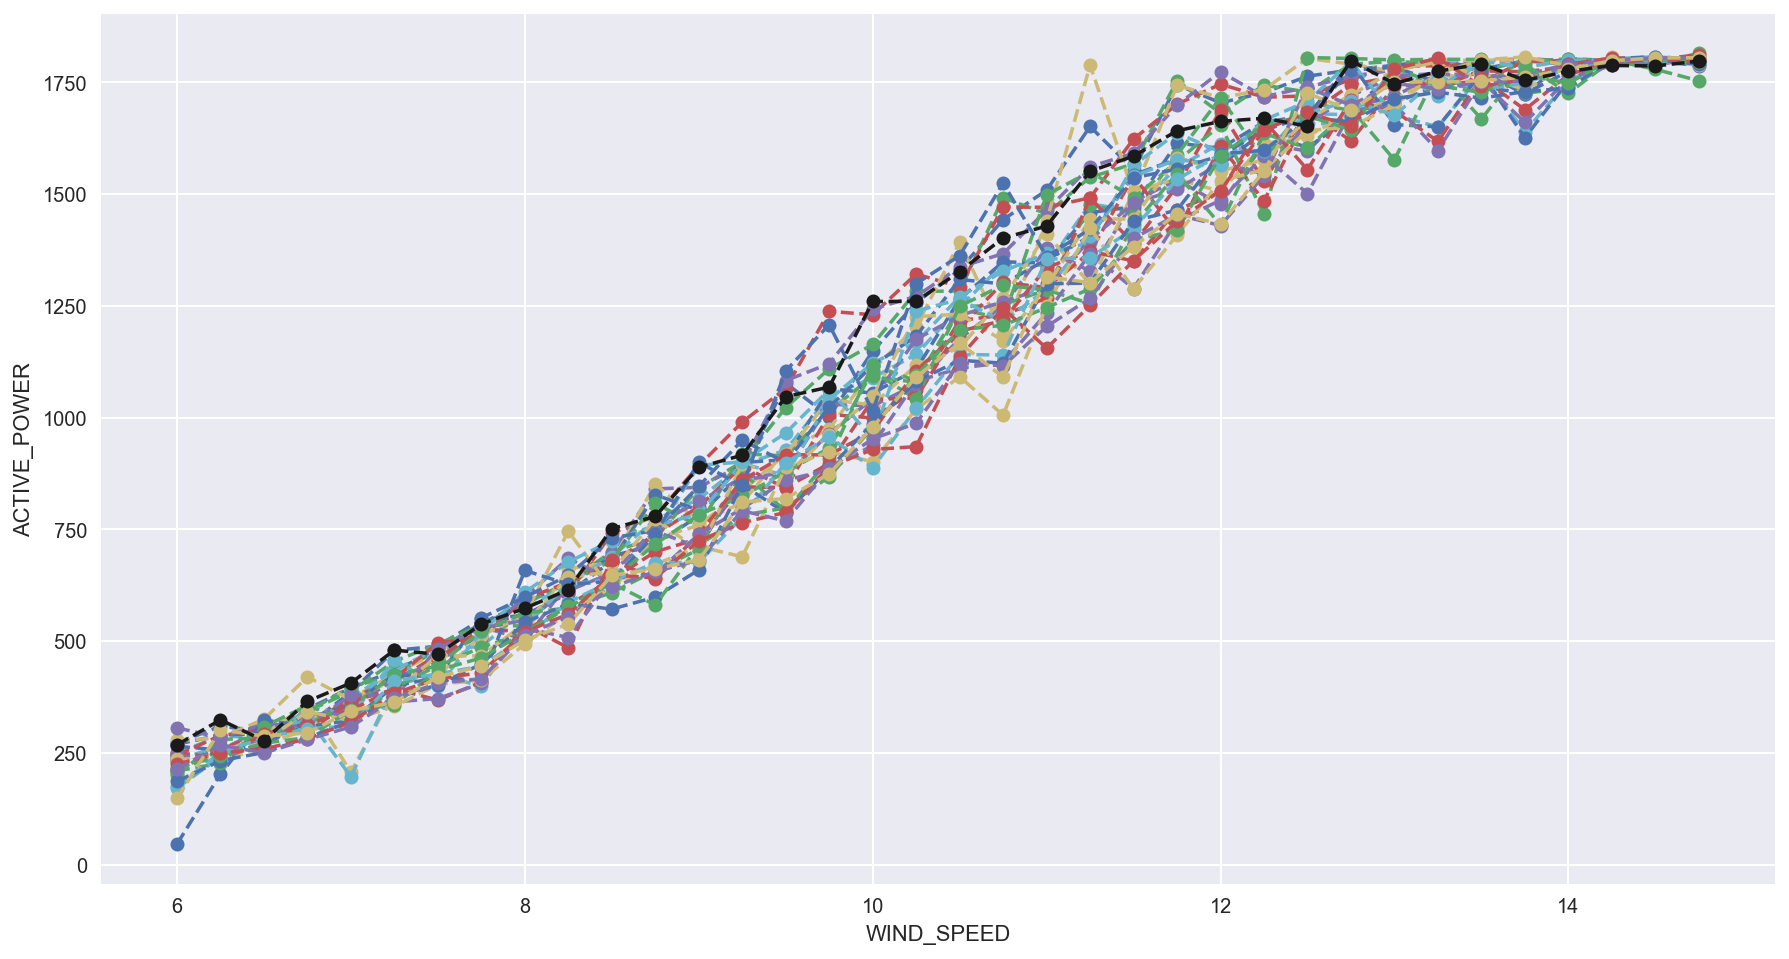

In [32]:
for week in weeks :
    bad = cleanwt[cleanwt['week'].isin(week)]
    b = getCenterLine(6,15,0.25,bad)
    plt.plot(b["x"],b['y'],'o--')
g = getCenterLine(6,15,0.25,good)
plt.plot(g["x"],g['y'],'ko--')
plt.xlabel("WIND_SPEED")
plt.ylabel("ACTIVE_POWER")
plt.show()

In [33]:
g = getCenterLine(6,15,0.25,good)
scores = []
for week in weeks :
    bad = cleanwt[cleanwt['week'].isin(week)]
    b = getCenterLine(6,15,0.25,bad)
    score = algo(g,b)
    scores.append(score)
    print("score {score} for weeks {week}".format(score=score,week=week))

score 7.8758146785833265 for weeks ['5-2016', '6-2016']
score 0.027142291126341034 for weeks ['6-2016', '7-2016']
score 0.05271127386012875 for weeks ['7-2016', '8-2016']
score 0.03962228343695062 for weeks ['8-2016', '9-2016']
score 0.08139375303202967 for weeks ['9-2016', '10-2016']
score -0.09271597942529874 for weeks ['18-2016', '19-2016']
score -0.07357862985234975 for weeks ['19-2016', '20-2016']
score -0.09029505396066129 for weeks ['20-2016', '21-2016']
score -0.09988681157577717 for weeks ['21-2016', '22-2016']
score -0.11804665815787652 for weeks ['22-2016', '23-2016']
score 7.892391086052571 for weeks ['23-2016', '24-2016']
score 7.890271718759561 for weeks ['07-2017', '8-2017']
score -0.0801463639142228 for weeks ['8-2017', '9-2017']
score 7.878908313734385 for weeks ['09-2017', '10-2017']
score -0.07036909579502715 for weeks ['10-2017', '11-2017']
score 7.892136694809457 for weeks ['11-2017', '12-2017']
score 7.88867687473118 for weeks ['12-2017', '13-2017']
score -0.00489

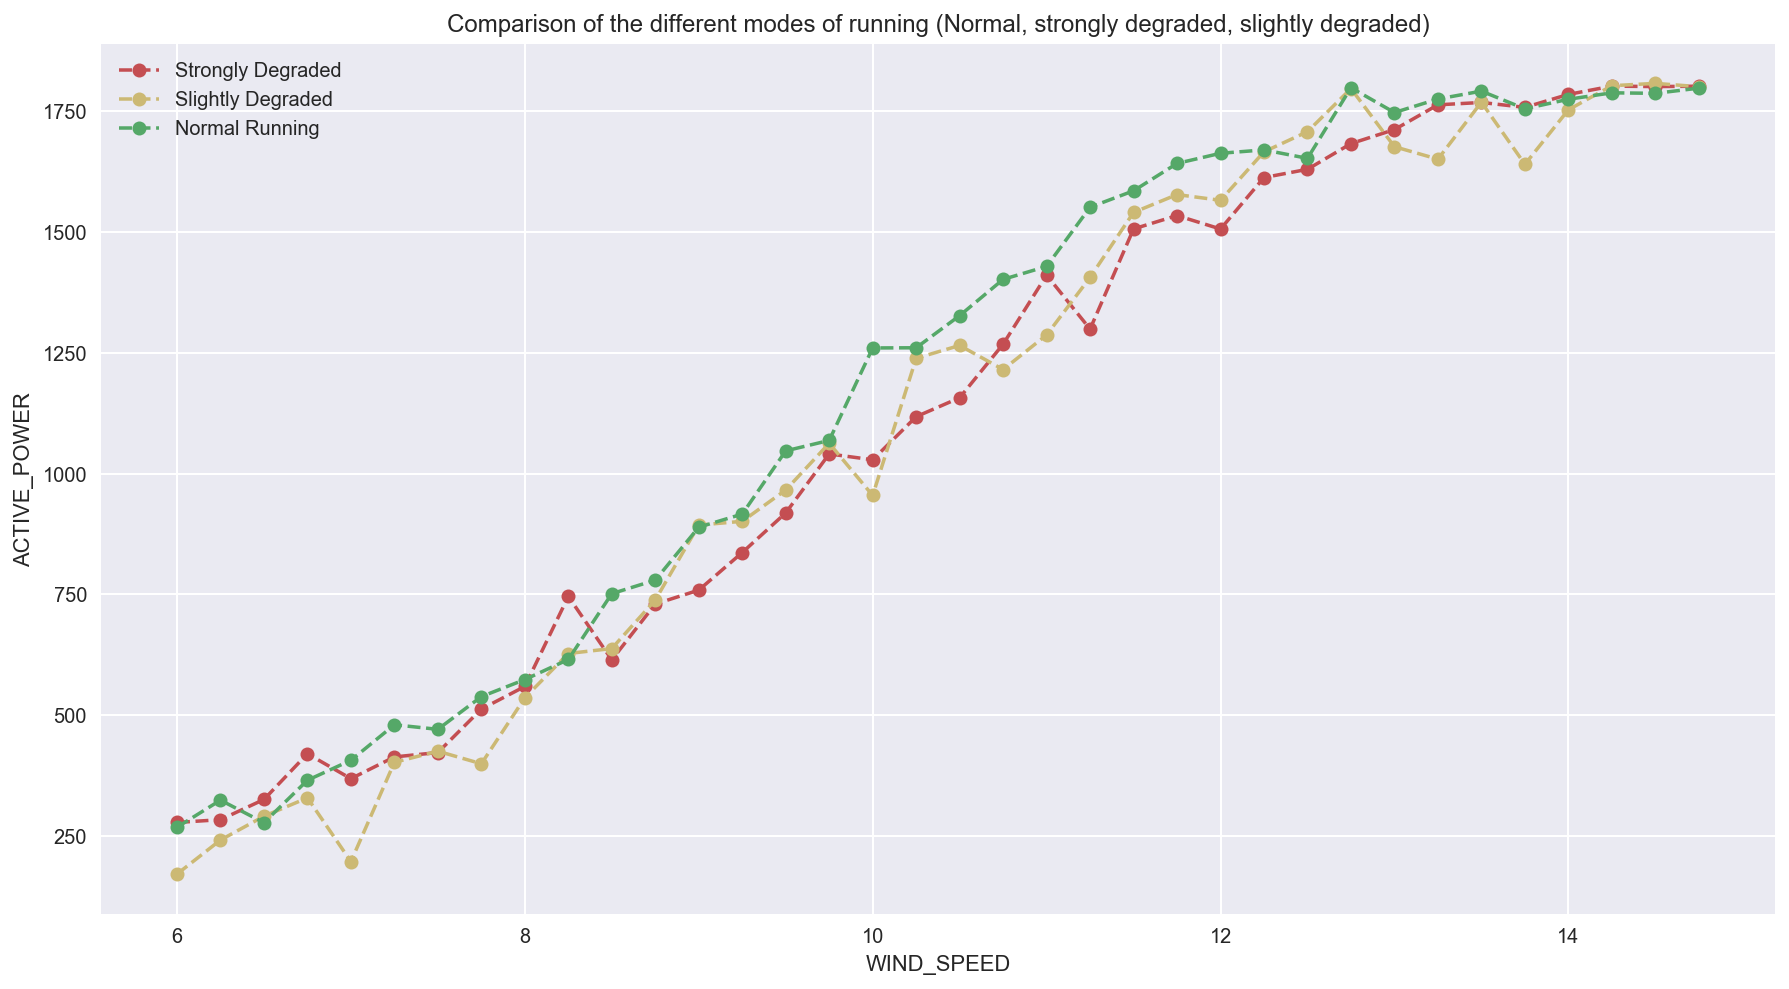

In [34]:
bad = cleanwt[cleanwt['week'].isin(weeks[scores.index(max(scores))])]
b = getCenterLine(6,15,0.25,bad)
plt.plot(b["x"],b['y'],'ro--')

ntb = cleanwt[cleanwt['week'].isin(weeks[scores.index(-0.004895140713763069)])]
ntb2 = getCenterLine(6,15,0.25,ntb)
plt.plot(ntb2["x"],ntb2['y'],'yo--')

g = getCenterLine(6,15,0.25,good)
plt.plot(g["x"],g['y'],'go--')

plt.xlabel("WIND_SPEED")
plt.ylabel("ACTIVE_POWER")
plt.legend(["Strongly Degraded","Slightly Degraded", "Normal Running"])
plt.title("Comparison of the different modes of running (Normal, strongly degraded, slightly degraded)")
plt.show()